# Binder Analytics
Analysing launches of this project in [MyBinder](https://mybinder.org).

In [1]:
%matplotlib inline
import datetime
import pandas as pd

from ipypb import track

## Get the source data
### Download the archive index

In [2]:
index = pd.read_json("https://archive.analytics.mybinder.org/index.jsonl",
                     lines=True)

The index.jsonl file lists all the dates an event archive is available for. The following fields are present for each line:

- date :: The UTC date the event archive is for
- name :: The name of the file containing the events. This is a relative path - since we got the index.jsonl file from https://archive.analytics.mybinder.org, that is the base URL used to resolve these. For example when name is events-2018-11-05.jsonl, the full URL to the file is https://archive.analytics.mybinder.org/events-2018-11-05.jsonl.
- count :: Total number of events in the file.


### Download the event archives

Get event archives for all the days since the first version of this repository was created:

In [3]:
now = datetime.datetime.now()
n = (now - datetime.datetime(2021, 8, 8)).days

pb = track(total=n, iterable=index.sort_index(ascending=False).iterrows())

frames = []
for idx, day in pb:
    frames.append(
        pd.read_json(f"https://archive.analytics.mybinder.org/{day['name']}",
                     lines=True)
    )

print(f"Fetched data for {n} days.")
df = pd.concat(frames)

 [████████████████████████████████████████████████████████████] 10/10 [01:03<00:09, 6.31s/it]

Fetched data for 10 days.


### Massage the data

Limit to records that are from my GitHub repositories, and reset the index.

In [4]:
df = df[(df['provider'] == 'GitHub') & (df['spec'].str.startswith('philipsd6'))].reset_index(drop=True)

Does it look right?

In [5]:
df.sample(3)

,timestamp,schema,version,provider,spec,ref,status,build_token,origin
35,2021-08-10 13:52:00+00:00,binderhub.jupyter.org/launch,5,GitHub,philipsd6/my-binder/61ade6ebbf27ba0c35047e2623...,61ade6ebbf27ba0c35047e26239d837bc077e080,success,True,gke.mybinder.org
0,2021-08-18 08:24:00+00:00,binderhub.jupyter.org/launch,5,GitHub,philipsd6/evaluation-binder/main,38fcb7fd53fbd3f70537c08dd47a004150f6a1d2,success,True,gke.mybinder.org
36,2021-08-10 13:55:00+00:00,binderhub.jupyter.org/launch,5,GitHub,philipsd6/my-binder/HEAD,61ade6ebbf27ba0c35047e26239d837bc077e080,success,True,gke.mybinder.org


Split the spec out into the repo/ref/commit. Often the ref is the same as the commit.

In [6]:
df['commit'] = df['ref']
df[['repo','ref']] = df['spec'].str.rsplit("/", 1, expand=True)

Drop unneeded columns and reindex in a nicer order.

In [7]:
df = df.drop(columns=['schema', 'version', 'provider', 'spec', 'status']).reindex(columns=['timestamp', 'build_token', 'origin', 'repo', 'ref', 'commit'])

Does it look better?

In [8]:
df.sample(3)

,timestamp,build_token,origin,repo,ref,commit
16,2021-08-15 21:11:00+00:00,True,gke.mybinder.org,philipsd6/evaluation-binder,main,35cff8492cbda1c1662c4d456d0af99c917a9567
43,2021-08-10 19:11:00+00:00,True,gke.mybinder.org,philipsd6/my-binder,main,86b550ab0c99f5fab307522c4ac213f77ce9c6f0
27,2021-08-11 07:32:00+00:00,True,gke.mybinder.org,philipsd6/my-binder,main,397d115aa3546cf4d67bb19cb2782306621107e1


## Analyze the data
### Total Launches

In [9]:
df.shape[0]

46

### Launches per day

In [10]:
daily = df.set_index("timestamp").resample('D').count()

<AxesSubplot:xlabel='timestamp'>

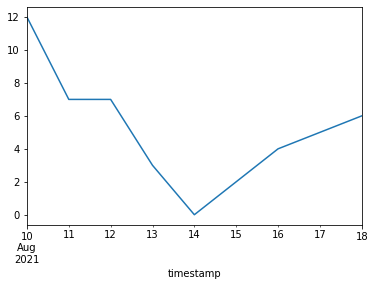

In [11]:
daily['repo'].plot()